In [5]:
'''!curl -O https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!curl -O https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
!tar -xf images.tar.gz
!tar -xf annotations.tar.gz'''

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0  755M    0 14175    0     0   7084      0 31:03:09  0:00:02 31:03:07  7087
  0  755M    0  435k    0     0   141k      0  1:31:16  0:00:03  1:31:13  141k
  0  755M    0 1317k    0     0   337k      0  0:38:09  0:00:03  0:38:06  337k
  0  755M    0 4044k    0     0   813k      0  0:15:50  0:00:04  0:15:46  813k
  0  755M    0 6724k    0     0  1143k      0  0:11:16  0:00:05  0:11:11 1358k
  1  755M    1 9002k    0     0  1309k      0  0:09:50  0:00:06  0:09:44 1844k
  1  755M    1 11.6M    0     0  1519k      0  0:08:29  0:00:07  0:08:22 2405k
  1  755M    1 14.7M    0     0  1697k      0  0:07:35  0:00:08  0:07:27 2758k
  2  755M    2 17.5M    0     0  1818k      0  0:07

In [1]:
import os
input_dir = '../images'
target_dir = '../annotations/trimaps'
img_size = (100, 160)
num_classes = 3
batch_size = 32
input_img_paths = sorted([os.path.join(input_dir, fname) 
                            for fname in os.listdir(input_dir)
                            if fname.endswith('.jpg')])

target_img_paths = sorted([os.path.join(target_dir, fname) 
                            for fname in os.listdir(target_dir)
                            if fname.endswith('.png') and not fname.startswith('.')])


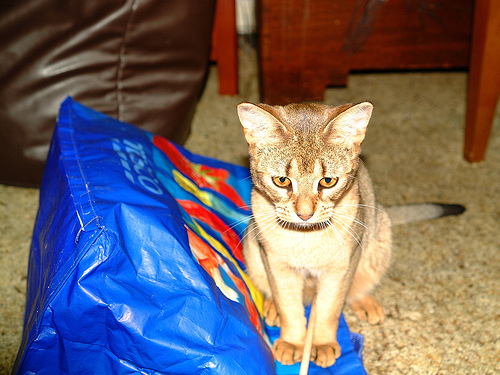

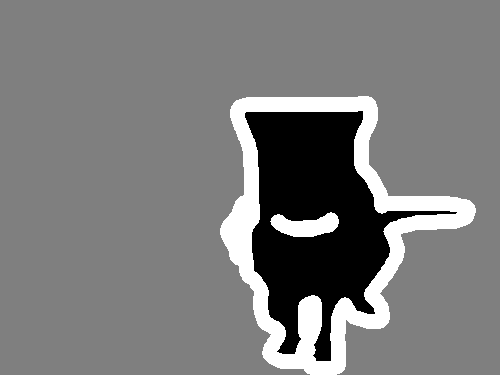

In [3]:
import tensorflow as tf
from IPython.display import Image, display
from tensorflow.keras.preprocessing.image import load_img
import PIL
from PIL import ImageOps
from PIL import Image as PILImg

display(Image(filename=input_img_paths[7]))
img = PIL.ImageOps.autocontrast(PILImg.open(target_img_paths[7]))
display(img)

# 데이터 전처리

In [4]:
import numpy as np
from tensorflow import keras
import random

class OxfordPets(keras.utils.Sequence):
    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

# 시퀀스에서 getitem으로 이미지를 하나씩 인덱스 별로 가져옴
    def __getitem__(self, idx):
        i = idx * self.batch_size # idx가 실제 i번쨰 위치가 되도록 함
        batch_input_img_paths = self.input_img_paths[i:i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i: i + self.batch_size]
        x = np.zeros((self.batch_size, ) + self.img_size + (3,), dtype='float32')

        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size = self.img_size)
            x[j] = img
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype = 'uint8')
        
        for j, paht in enumerate(batch_target_img_paths):
            img = load_img(path, target_size = self.img_size, color_mode = 'grayscale')
            y[j] = np.expand_dims(img, 2)
            y[j] -= 1

        return x, y


In [5]:
val_samples = 1000
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_img_paths)

train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

train_gen = OxfordPets(batch_size, img_size, train_input_img_paths, train_target_img_paths)
val_gen = OxfordPets(batch_size, img_size, val_input_img_paths, val_target_img_paths)



In [21]:
len(train_gen)

199

### 모델 구성

In [6]:
from tensorflow.keras import layers

def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))
    x = layers.Conv2D(32, 3, strides = 2, padding = 'same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    previous_block_activation = x

    for filters in [64, 128, 256]:
        x = layers.Activation('relu')(x)
        x = layers.SeparableConv2D(filters, 3, padding = 'same')(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation('relu')(x)
        x = layers.SeparableConv2D(filters, 3, padding = 'same')(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides = 2, padding = 'same')(x)

        residual = layers.Conv2D(filters, 1, strides = 2, padding = 'same')(previous_block_activation)
        x = layers.add([x, residual])
        previous_block_activation = x
        

    for filters in [256, 128, 64, 32]:
        x = layers.Activation('relu')(x)
        x = layers.Conv2DTranspose(filters, 3, padding = 'same')(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation('relu')(x)
        x = layers.Conv2DTranspose(filters, 3, padding = 'same')(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding = "same")(residual)
        x = layers.add([x, residual])
        previous_block_activation = x

    outputs = layers.Conv2D(num_classes, 3, activation = 'softmax', padding = 'same')(x)

    model = keras.Model(inputs, outputs)
    return model

model = get_model(img_size, num_classes)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 50, 80, 32)   896         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 50, 80, 32)  128         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

## 모델 학습

In [22]:
print(len(train_gen), len(val_gen))

199 31


In [7]:
model.compile(optimizer = 'rmsprop', loss = 'sparse_categorical_crossentropy')
callbacks = [keras.callbacks.ModelCheckpoint('oxford_segmentation.h5', save_best_only=True)]
epochs = 20
model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)

Epoch 1/20


InvalidArgumentError:  logits and labels must have the same first dimension, got logits shape [573440,3] and labels shape [512000]
	 [[node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits
 (defined at c:\Users\PiusHwang\Anaconda3\envs\aicomp\lib\site-packages\keras\backend.py:5113)
]] [Op:__inference_train_function_6708]

Errors may have originated from an input operation.
Input Source operations connected to node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits:
In[0] sparse_categorical_crossentropy/Reshape_1 (defined at c:\Users\PiusHwang\Anaconda3\envs\aicomp\lib\site-packages\keras\backend.py:5109)	
In[1] sparse_categorical_crossentropy/Reshape (defined at c:\Users\PiusHwang\Anaconda3\envs\aicomp\lib\site-packages\keras\backend.py:3561)

Operation defined at: (most recent call last)
>>>   File "c:\Users\PiusHwang\Anaconda3\envs\aicomp\lib\runpy.py", line 194, in _run_module_as_main
>>>     return _run_code(code, main_globals, None,
>>> 
>>>   File "c:\Users\PiusHwang\Anaconda3\envs\aicomp\lib\runpy.py", line 87, in _run_code
>>>     exec(code, run_globals)
>>> 
>>>   File "c:\Users\PiusHwang\Anaconda3\envs\aicomp\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
>>>     app.launch_new_instance()
>>> 
>>>   File "c:\Users\PiusHwang\Anaconda3\envs\aicomp\lib\site-packages\traitlets\config\application.py", line 976, in launch_instance
>>>     app.start()
>>> 
>>>   File "c:\Users\PiusHwang\Anaconda3\envs\aicomp\lib\site-packages\ipykernel\kernelapp.py", line 712, in start
>>>     self.io_loop.start()
>>> 
>>>   File "c:\Users\PiusHwang\Anaconda3\envs\aicomp\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
>>>     self.asyncio_loop.run_forever()
>>> 
>>>   File "c:\Users\PiusHwang\Anaconda3\envs\aicomp\lib\asyncio\base_events.py", line 570, in run_forever
>>>     self._run_once()
>>> 
>>>   File "c:\Users\PiusHwang\Anaconda3\envs\aicomp\lib\asyncio\base_events.py", line 1859, in _run_once
>>>     handle._run()
>>> 
>>>   File "c:\Users\PiusHwang\Anaconda3\envs\aicomp\lib\asyncio\events.py", line 81, in _run
>>>     self._context.run(self._callback, *self._args)
>>> 
>>>   File "c:\Users\PiusHwang\Anaconda3\envs\aicomp\lib\site-packages\ipykernel\kernelbase.py", line 504, in dispatch_queue
>>>     await self.process_one()
>>> 
>>>   File "c:\Users\PiusHwang\Anaconda3\envs\aicomp\lib\site-packages\ipykernel\kernelbase.py", line 493, in process_one
>>>     await dispatch(*args)
>>> 
>>>   File "c:\Users\PiusHwang\Anaconda3\envs\aicomp\lib\site-packages\ipykernel\kernelbase.py", line 400, in dispatch_shell
>>>     await result
>>> 
>>>   File "c:\Users\PiusHwang\Anaconda3\envs\aicomp\lib\site-packages\ipykernel\kernelbase.py", line 724, in execute_request
>>>     reply_content = await reply_content
>>> 
>>>   File "c:\Users\PiusHwang\Anaconda3\envs\aicomp\lib\site-packages\ipykernel\ipkernel.py", line 383, in do_execute
>>>     res = shell.run_cell(
>>> 
>>>   File "c:\Users\PiusHwang\Anaconda3\envs\aicomp\lib\site-packages\ipykernel\zmqshell.py", line 528, in run_cell
>>>     return super().run_cell(*args, **kwargs)
>>> 
>>>   File "c:\Users\PiusHwang\Anaconda3\envs\aicomp\lib\site-packages\IPython\core\interactiveshell.py", line 2881, in run_cell
>>>     result = self._run_cell(
>>> 
>>>   File "c:\Users\PiusHwang\Anaconda3\envs\aicomp\lib\site-packages\IPython\core\interactiveshell.py", line 2936, in _run_cell
>>>     return runner(coro)
>>> 
>>>   File "c:\Users\PiusHwang\Anaconda3\envs\aicomp\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
>>>     coro.send(None)
>>> 
>>>   File "c:\Users\PiusHwang\Anaconda3\envs\aicomp\lib\site-packages\IPython\core\interactiveshell.py", line 3135, in run_cell_async
>>>     has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
>>> 
>>>   File "c:\Users\PiusHwang\Anaconda3\envs\aicomp\lib\site-packages\IPython\core\interactiveshell.py", line 3338, in run_ast_nodes
>>>     if await self.run_code(code, result, async_=asy):
>>> 
>>>   File "c:\Users\PiusHwang\Anaconda3\envs\aicomp\lib\site-packages\IPython\core\interactiveshell.py", line 3398, in run_code
>>>     exec(code_obj, self.user_global_ns, self.user_ns)
>>> 
>>>   File "C:\Users\PiusHwang\AppData\Local\Temp\ipykernel_436\3504000479.py", line 4, in <cell line: 4>
>>>     model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)
>>> 
>>>   File "c:\Users\PiusHwang\Anaconda3\envs\aicomp\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "c:\Users\PiusHwang\Anaconda3\envs\aicomp\lib\site-packages\keras\engine\training.py", line 1216, in fit
>>>     tmp_logs = self.train_function(iterator)
>>> 
>>>   File "c:\Users\PiusHwang\Anaconda3\envs\aicomp\lib\site-packages\keras\engine\training.py", line 878, in train_function
>>>     return step_function(self, iterator)
>>> 
>>>   File "c:\Users\PiusHwang\Anaconda3\envs\aicomp\lib\site-packages\keras\engine\training.py", line 867, in step_function
>>>     outputs = model.distribute_strategy.run(run_step, args=(data,))
>>> 
>>>   File "c:\Users\PiusHwang\Anaconda3\envs\aicomp\lib\site-packages\keras\engine\training.py", line 860, in run_step
>>>     outputs = model.train_step(data)
>>> 
>>>   File "c:\Users\PiusHwang\Anaconda3\envs\aicomp\lib\site-packages\keras\engine\training.py", line 809, in train_step
>>>     loss = self.compiled_loss(
>>> 
>>>   File "c:\Users\PiusHwang\Anaconda3\envs\aicomp\lib\site-packages\keras\engine\compile_utils.py", line 201, in __call__
>>>     loss_value = loss_obj(y_t, y_p, sample_weight=sw)
>>> 
>>>   File "c:\Users\PiusHwang\Anaconda3\envs\aicomp\lib\site-packages\keras\losses.py", line 141, in __call__
>>>     losses = call_fn(y_true, y_pred)
>>> 
>>>   File "c:\Users\PiusHwang\Anaconda3\envs\aicomp\lib\site-packages\keras\losses.py", line 245, in call
>>>     return ag_fn(y_true, y_pred, **self._fn_kwargs)
>>> 
>>>   File "c:\Users\PiusHwang\Anaconda3\envs\aicomp\lib\site-packages\keras\losses.py", line 1737, in sparse_categorical_crossentropy
>>>     return backend.sparse_categorical_crossentropy(
>>> 
>>>   File "c:\Users\PiusHwang\Anaconda3\envs\aicomp\lib\site-packages\keras\backend.py", line 5113, in sparse_categorical_crossentropy
>>>     res = tf.nn.sparse_softmax_cross_entropy_with_logits(
>>> 

# DeepLab 기반 세그멘테이션

* DeepLab V1: [Semantic Image Segmentation with Deep Convolutional Nets and Fully Connected CRFs](https://arxiv.org/abs/1412.7062), ICLR 2015.
  - Atrous convolution은 기존 convolution과 다르게 필터 내부에 빈 공간을 둔 채로 작동
  - 기존 convolution과 동일한 양의 파라미터와 계산량을 유지하면서 field of view (한 픽셀이 볼 수 있는 영역)를 크게 가져갈 수 있음
  - Semantic segmentation에서 일반적으로 높은 성능을 내기 위해서는 convolutional neural network의 마지막에 존재하는 한 픽셀이 입력값에서 어느 크기의 영역을 커버할 수 있는지를 결정하는 receptive field 크기가 중요
  - Atrous convolution을 활용하면 파라미터 수를 늘리지 않으면서도 receptive field를 크게 키울 수 있기 때문에 DeepLab 계열에서는 이를 적극적으로 활용

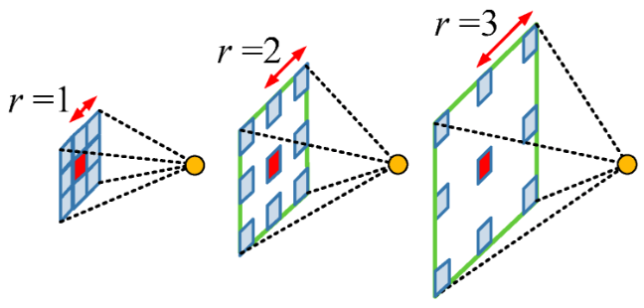

* DeepLab V2: [DeepLab: Semantic Image Segmentation with Deep Convolutional Nets, Atrous Convolution, and Fully Connected CRFs](https://arxiv.org/abs/1606.00915), TPAMI 2017.
  - Semantic segmentaion의 성능을 높이기 위한 방법 중 하나로, spatial pyramid pooling 기법을 자주 사용
  - Feature map으로부터 여러 개의 rate가 다른 atrous convolution을 병렬로 적용한 뒤, 이를 다시 합쳐주는 atrous spatial pyramid pooling (ASPP) 기법을 활용
  - multi-scale context를 모델 구조로 구현하여 보다 정확한 semantic segmentation을 수행할 수 있도록 함

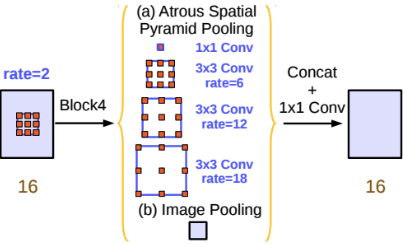

* DeepLab V3: [Rethinking Atrous Convolution for Semantic Image Segmentation](https://arxiv.org/abs/1706.05587), arXiv 2017.

  - Encoder: ResNet with Atrous convolution
  - Atrous Spatial Pyramid Pooling (ASPP)
  - Decoder: Bilinear Upsampling


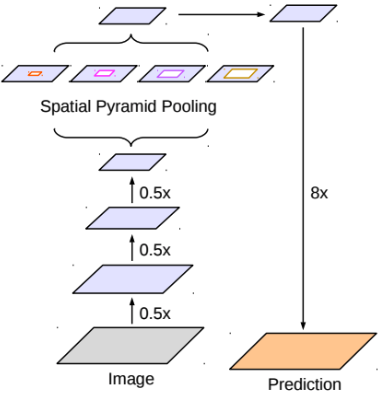

* DeepLab V3+: [Encoder-Decoder with Atrous Separable Convolution for Semantic Image Segmentation](https://arxiv.org/pdf/1802.02611.pdf), arXiv 2018.

  - Encoder: ResNet with Atrous Convolution → Xception (Inception with Separable Convolution)
  - ASPP → ASSPP (Atrous Separable Spatial Pyramid Pooling)
  - Decoder: Bilinear Upsampling → Simplified U-Net style decoder

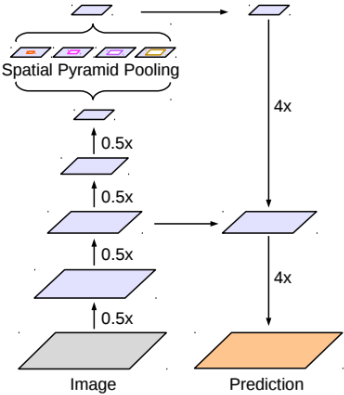

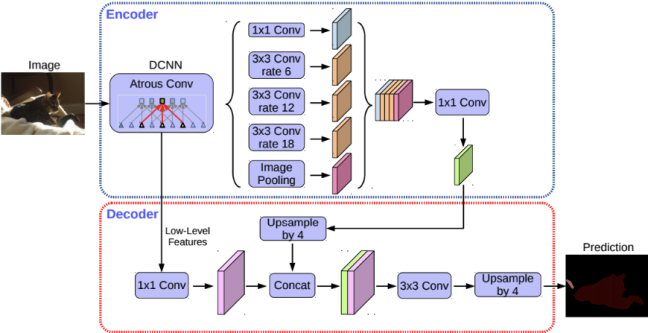

## 데이터셋 다운로드

* Crowd Instance-level Human Parsing (CIHP)(https://arxiv.org/abs/1811.12596)
* 38,280개의 다양한 인간 이미지
* instance-level-human-parsing.zip(2.7G): https://drive.google.com/uc?id=1B9A9UCJYMwTL4oBEo4RZfbMZMaZhKJaz

In [23]:
import os
import cv2
import numpy as np
from glob import glob
from scipy.io import loadmat

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
#!gdown https://drive.google.com/uc?id=1B9A9UCJYMwTL4oBEo4RZfbMZMaZhKJaz
#!unzip -q instance-level-human-parsing.zip

In [1]:
IMAGE_SIZE = 512
BATCH_SIZE = 4
NUM_CLASSES = 20
DATA_DIR = "./instance-level_human_parsing/instance-level_human_parsing/Training"
NUM_TRAIN_IMAGES = 1000
NUM_VAL_IMAGES = 50

In [2]:
train_images = sorted(glob(os.path.join(DATA_DIR, 'Images/*')))[:NUM_TRAIN_IMAGES]
train_masks = sorted(glob(os.path.join(DATA_DIR+'Category_ids/*')))[:NUM_TRAIN_IMAGES]
val_images = sorted(glob(os.path.join(DATA_DIR+'Images/*')))[NUM_TRAIN_IMAGES:NUM_TRAIN_IMAGES+NUM_VAL_IMAGES]
val_masks = sorted(glob(os.path.join(DATA_DIR+'Category_ids/*')))[NUM_TRAIN_IMAGES:NUM_TRAIN_IMAGES+NUM_VAL_IMAGES]


NameError: name 'glob' is not defined